In [206]:
#1.데이터 로드
import numpy as np
import pandas as pd
train = pd.read_csv('data/train.csv')

X_train = train.drop(columns='Survived')
y_train = train['Survived']

X_test = pd.read_csv('data/test.csv')
PassengerId = X_test['PassengerId'].copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Survived
0    549
1    342
Name: count, dtype: int64

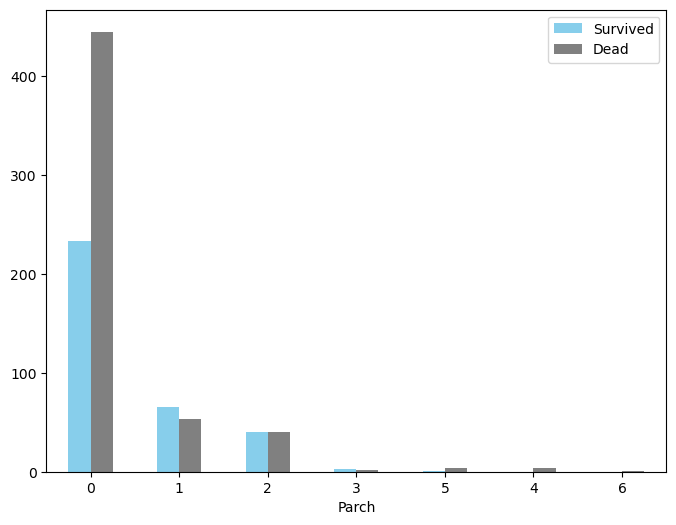

In [207]:
#2.EDA
import seaborn as sns

def graph(variable):
    survived = train[train['Survived']==1][variable].value_counts()
    dead = train[train['Survived']==0][variable].value_counts()
    result = pd.DataFrame([survived,dead])
    result.index = ['Survived','Dead']
    result.T.plot(kind='bar', color=['skyblue','gray'], rot=0, figsize=(8,6))

print(train.info())
#graph('Parch')

In [208]:
#3.데이터 정제

#print(X_train.info())
#print(X_train['Fare'].unique())
#print(X_train.select_dtypes('object').nunique())

#불필요한 컬럼 제거
X_train = X_train.drop(columns=['PassengerId','Name','Ticket','Cabin'])
X_test = X_test.drop(columns=['PassengerId','Name','Ticket','Cabin'])

#SibSp, Parch 컬럼 통합
X_train['family'] = X_train['SibSp']+X_train['Parch']
X_train = X_train.drop(columns=['SibSp','Parch'])

X_test['family'] = X_test['SibSp']+X_test['Parch']
X_test = X_test.drop(columns=['SibSp','Parch'])

In [209]:
#4.결측치 처리
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].mean())

X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].value_counts().idxmax())
X_test['Embarked'] = X_test['Embarked'].fillna(X_train['Embarked'].value_counts().idxmax())

X_train['Fare'] = X_train['Fare'].fillna(X_train['Fare'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_train['Fare'].mean())

In [210]:
# #BK_4.Age컬럼 결측치 대체법
# #범주형은 인코딩하고, corr()을 이용해서 상관계수 높은 컬럼 추출

# #print(X_train.info())
# #print(X_train.select_dtypes('object').nunique())

# #X_train = pd.get_dummies(X_train,columns=['Sex','Embarked'])

# #X_train[['Age','Fare','Parch','SibSp','Pclass','Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S','Family']].corr()['Age']

# #그 컬럼별 group by해서 age 평균을 각 행의 결측치에 대체

# Age_By_train = pd.DataFrame(X_train.groupby(['Pclass','family'])['Age'].mean())
# Age_By_train = Age_By_train.reset_index()

# Age_By_test = pd.DataFrame(X_test.groupby(['Pclass','family'])['Age'].mean())
# Age_By_test = Age_By_test.reset_index()


# for index, row in Age_By_Pclass.iterrows():
#     X_train.loc[(X_train['Pclass'] == row['Pclass']) & (X_train['family'] == row['family']) & (X_train['Age'].isna()), 'Age'] = row['Age']
#     X_test.loc[(X_test['Pclass'] == row['Pclass']) & (X_test['family'] == row['family']) & (X_test['Age'].isna()), 'Age'] = row['Age']

# # import seaborn as sns
# # import matplotlib.pyplot as plt

# # fig,ax = plt.subplots(2,figsize=(40,30))
# # sns.countplot(data=X_train,x='Age',ax=ax[0])
# # sns.countplot(data=X_test,x='Age',ax=ax[1])
# # plt.show()

In [211]:
#5.인코딩
X_train = pd.get_dummies(X_train,columns=['Sex','Embarked','Pclass'])
X_test = pd.get_dummies(X_test,columns=['Sex','Embarked','Pclass'])

X_train_enc = X_train.select_dtypes('bool').astype('int')
X_test_enc = X_test.select_dtypes('bool').astype('int')

In [212]:
#6.스케일링
from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(exclude='bool').copy()
X_test_num = X_test.select_dtypes(exclude='bool').copy()

scale = StandardScaler().fit(X_train_num)

X_train_std = scale.transform(X_train_num)
X_test_std = scale.transform(X_test_num)

X_train_std = pd.DataFrame(X_train_std,columns=['Age','family','Fare'])
X_test_std = pd.DataFrame(X_test_std,columns=['Age','family','Fare'])

X_train = pd.concat([X_train_std,X_train_enc],axis=1)
X_test = pd.concat([X_test_std,X_test_enc],axis=1)

In [213]:
#7.특성 선택
import statsmodels.api as sm

X = X_train.drop(columns=['Sex_male','Embarked_C','Pclass_1'])
y = y_train
test = X_test.drop(columns=['Sex_male','Embarked_C','Pclass_1'])

model = sm.Logit(y,X)
model_fit = model.fit()
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.441100
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 May 2024   Pseudo R-squ.:                  0.3376
Time:                        19:51:40   Log-Likelihood:                -393.02
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.760e-82
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.4924      0.100     -4.935      0.000      -0.688      -0.297
family         0.1431      0.

In [214]:
#8.데이터 분리하기
from sklearn.model_selection import train_test_split

X = X_train[['Age','Fare','Sex_female','Embarked_S','Pclass_2','Pclass_3']]
y = y_train
test = X_test[['Age','Fare','Sex_female','Embarked_S','Pclass_2','Pclass_3']]

X1, X2, y1, y2 = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=999)

In [215]:
#9.모델 학습 및 예측
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#LogisticRegression
model_lr = LogisticRegression(random_state=999)
model_lr.fit(X1,y1)
y_predict_lr = model_lr.predict(X2)

#RandomForestClassifier
model_rf = RandomForestClassifier(
                    max_depth=7,
                    n_estimators=200,
                    max_features='sqrt',
                    min_samples_split=2,
                    min_samples_leaf=1,
                    random_state=999)
model_rf.fit(X1,y1)
y_predict_rf = model_rf.predict(X2)

#XGBClassifier
model_xgb = XGBClassifier(
                    objective = 'binary:logistic',
                    max_depth = 4,
                    n_estimators = 18,
                    random_state = 999)
model_xgb.fit(X1,y1)
y_predict_xgb = model_xgb.predict(X2)

#LGBMClassifier
model_lgbm = LGBMClassifier(
                    max_depth = 4,
                    num_leaves = 2,
                    n_estimators = 400,
                    min_child_weight = 10,
                    learning_rate = 0.2,
                    objective = 'binary',
                    random_state = 999)
model_lgbm.fit(X1,y1)
y_predict_lgbm = model_lgbm.predict(X2)

#CatBoostClassifier
model_cat = CatBoostClassifier(
                    depth=2,
                    iterations=100,
                    learning_rate=0.2, 
                    loss_function='MultiClass')
model_cat.fit(X1,y1,verbose=False)
y_predict_cat = model_cat.predict(X2)
y_predict_cat = np.array(y_predict_cat).flatten() #array in array 형태를 array로 변환

[LightGBM] [Info] Number of positive: 245, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393258 -> initscore=-0.433636
[LightGBM] [Info] Start training from score -0.433636


In [216]:
#10.평가
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score

print(accuracy_score(y2,y_predict_lr).round(3))
print(accuracy_score(y2,y_predict_rf).round(3))
print(accuracy_score(y2,y_predict_xgb).round(3))
print(accuracy_score(y2,y_predict_lgbm).round(3))
print(accuracy_score(y2,y_predict_cat).round(3))

# print(f1_score(y2,y_predict_lr).round(3))
# probas_lr = model_lr.predict_proba(X2)
# print(roc_auc_score(y2,probas_lr[:,1]).round(3))

0.802
0.81
0.81
0.795
0.817


In [217]:
#11.제출
#XGBClassifier
model_rf = RandomForestClassifier(
                    max_depth=7,
                    n_estimators=200,
                    max_features='sqrt',
                    min_samples_split=2,
                    min_samples_leaf=1,
                    random_state=999)
model_rf.fit(X,y)
y_predict_rf = model_rf.predict(test)

obj = {'PassengerId':PassengerId,'Survived':y_predict_rf}
result = pd.DataFrame(obj)
result.to_csv('result/result.csv', index = False)